# CIC prediction

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings("ignore")

output_folder = './validation_report/CIC'
today = pd.Timestamp.today().strftime('%Y-%m-%d')

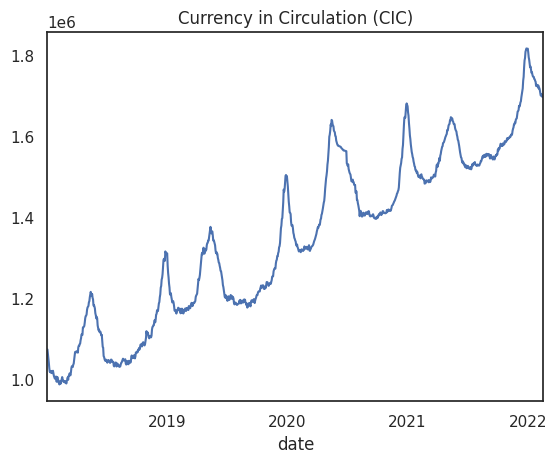

In [16]:
CIC = pd.read_excel('../data/CIC.xlsx', parse_dates=['date'], index_col='date')
CIC['CIC'].plot(title = 'Currency in Circulation (CIC)'); plt.show()

In [17]:
holiday_type = pd.read_excel('../data/holidays.xlsx', parse_dates=['date'], index_col='date')
holiday_type = pd.get_dummies(holiday_type['Type']).astype(int)
holiday_type = holiday_type.resample('B').last().fillna(0)

data = CIC.merge(holiday_type, how='left', left_index=True, right_index=True).fillna(0)

## Section 2: Model Definition

In [18]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.statsforecast import (
    StatsForecastAutoARIMA,
    StatsForecastAutoETS,
    StatsForecastAutoCES, 
    StatsForecastAutoTheta,
    StatsForecastAutoTBATS,
)

ForecastingModels = {
    "Naive": NaiveForecaster(),
    "Seasonal_Naive": NaiveForecaster(sp = 5),
    "AutoARIMA": StatsForecastAutoARIMA(
                    trend=True, seasonal=True,
                    max_D = 262, max_p= 10, max_q=10),
    "AutoETS": StatsForecastAutoETS(season_length=262),
    "AutoCES": StatsForecastAutoCES(season_length=262),
    "AutoTheta": StatsForecastAutoTheta(season_length=262),
    "AutoTBATS": StatsForecastAutoTBATS(seasonal_periods=262, 
                                        use_trend =True, use_boxcox=True)
}
from forecast_combine import model_select as f
model = f.ForecastModelSelect(
            data= data,
            depvar_str = 'CIC',                 
            exog_l=None,
            fh = 10,
            pct_initial_window=0.75,
            step_length = 5,
            forecasters_d= ForecastingModels,
            freq = 'B',
            mode = 'best_horizon',
            score = 'RMSE', 
            nbest = 2)

### Cross validation Procedure

In [19]:
_ = model.split_procedure_summary()

Number of Folds      : 53
Initial Window Size  : 808
Step Length          : 5
Forecast Horizon     : 10
First Cutoff         : 2021-02-05 00:00:00
Last Curoff          : 2022-02-04 00:00:00


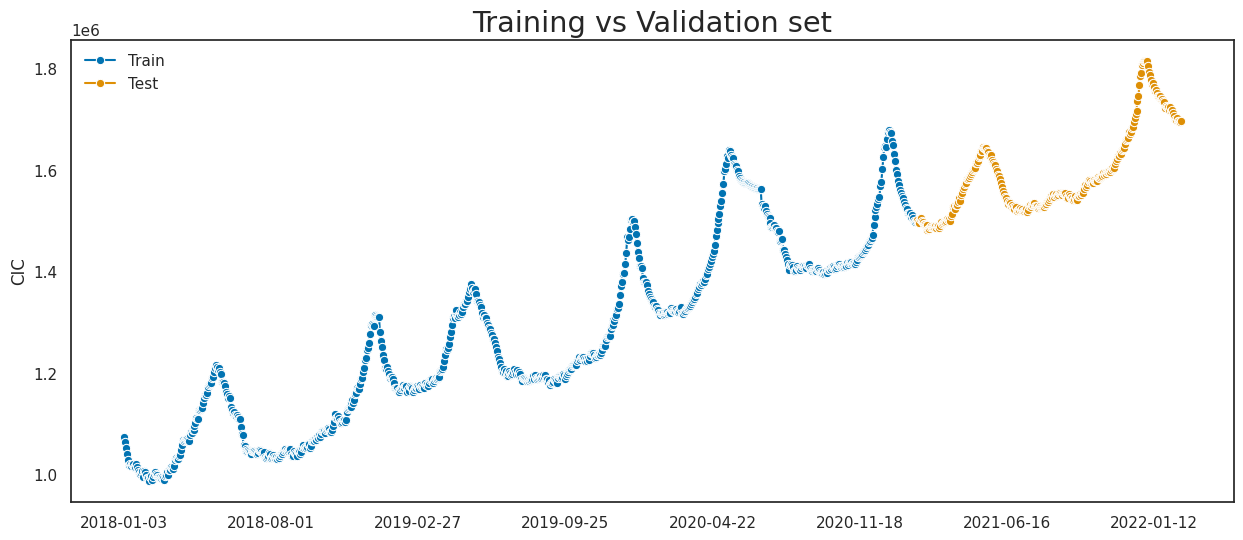

In [20]:
f, ax = model.plot_train_test(labels = ['Train', 'Test'], title='Training vs Validation set')
plt.savefig(os.path.join(output_folder, f'train_test_{today}.png'), dpi=300)

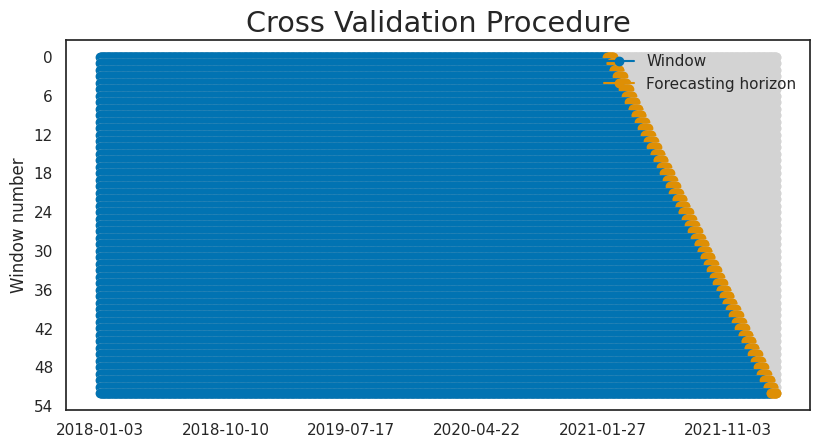

In [21]:
f = model.plot_cv_procedure(xlabel='')
plt.savefig(os.path.join(output_folder, f'cross_validation_{today}.png'), dpi=300)

### Out-Of-sample Evaluation

In [22]:
summary_horizon, summary_results = model.evaluate()


Start Naive forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 99.46it/s] 


Evaluation completed in: 1 seconds
Fitting the model Naive on the entire sample ...
Model fitted in 0 seconds

Start Seasonal_Naive forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 89.13it/s] 


Evaluation completed in: 1 seconds
Fitting the model Seasonal_Naive on the entire sample ...
Model fitted in 0 seconds

Start AutoARIMA forecaster evaluation....


100%|██████████| 51/51 [00:01<00:00, 40.14it/s]


Evaluation completed in: 1 seconds
Fitting the model AutoARIMA on the entire sample ...
Model fitted in 0 seconds

Start AutoETS forecaster evaluation....


100%|██████████| 51/51 [01:03<00:00,  1.25s/it]


Evaluation completed in: 1 minutes, 8 seconds
Fitting the model AutoETS on the entire sample ...
Model fitted in 8 seconds

Start AutoCES forecaster evaluation....


100%|██████████| 51/51 [00:02<00:00, 18.73it/s]


Evaluation completed in: 3 seconds
Fitting the model AutoCES on the entire sample ...
Model fitted in 1 seconds

Start AutoTheta forecaster evaluation....


100%|██████████| 51/51 [00:00<00:00, 59.13it/s]


Evaluation completed in: 1 seconds
Fitting the model AutoTheta on the entire sample ...
Model fitted in 0 seconds

Start AutoTBATS forecaster evaluation....


100%|██████████| 51/51 [00:09<00:00,  5.12it/s]


Evaluation completed in: 12 seconds
Fitting the model AutoTBATS on the entire sample ...
Model fitted in 3 seconds


In [23]:
display(summary_results.T.sort_values('Avg MAPE'))
display(summary_horizon.T)

,Number of Folds,Number of Predictions,Avg Fit time (s),Avg_pred_time (s),Smallest training window,Largest training window,First cutoff,Last cutoff,Avg RMSE,Avg MAE,Avg MAPE,Avg R2,Avg MedianAE
AutoCES,51,312,1.85714,0.005676,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,15351.415052,13625.472132,0.008481,-10.105927,13368.90896
AutoETS,51,312,55.029293,0.022316,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,19543.459671,17460.59244,0.010672,-6.395744,16930.835854
Naive,51,312,0.004638,0.043264,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,19540.605702,17514.897328,0.010717,-4.723505,17498.937023
AutoTBATS,51,312,7.421939,0.008767,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,19810.212516,17479.491451,0.010809,-13.867529,17048.547588
AutoTheta,51,312,0.46689,0.005869,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,22892.798759,21008.283731,0.012833,-7.692174,20987.867128
Seasonal_Naive,51,312,0.003539,0.02502,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,24205.800255,22143.29313,0.013539,-8.458669,22748.30916
AutoARIMA,51,312,0.541868,0.005431,807,1057,2021-02-05 00:00:00,2022-02-07 00:00:00,26608.060632,24187.042098,0.014686,-23.975296,23816.70551


horizon                            1             2             3   \
Naive          RMSE       8052.486965  11489.715107  14835.728115   
               MAE        5982.730769   8521.217949  10946.298077   
               MAPE          0.003705      0.005248      0.006719   
               R2            0.990835      0.981405      0.969134   
               MedianAE   4581.500000   6809.000000   8928.000000   
Seasonal_Naive RMSE      18932.754006  19000.787711  18905.782932   
               MAE       13979.714744  13982.782051  13880.929487   
               MAPE          0.008573      0.008572      0.008504   
               R2            0.949334      0.949148      0.949875   
               MedianAE  10858.000000  10718.500000  10643.000000   
AutoARIMA      RMSE      14666.303327  23076.918765  31916.434147   
               MAE       10137.700794  14425.057626  18429.269501   
               MAPE          0.006234      0.008810      0.011204   
               R2            0.969596      0.924990      0.857146   
               MedianAE   6913.286627   9658.595201  11086.596973   
AutoETS        RMSE      12229.061820  14562.041124  16988.726755   
               MAE        8355.299377   9965.278208  11898.535925   
               MAPE          0.005151      0.006136      0.007305   
               R2            0.978861      0.970132      0.959525   
               MedianAE   6005.383553   7231.107030   8230.742856   
AutoCES        RMSE      11568.409317  13596.664561  14314.018603   
               MAE        8228.772203   9766.078661  10779.249020   
               MAPE          0.005108      0.006061      0.006681   
               R2            0.981084      0.973961      0.971267   
               MedianAE   5729.191895   7254.050781   7750.209961   
AutoTheta      RMSE      14535.774258  17705.338904  20763.645544   
               MAE       10168.222356  12702.695112  15150.962740   
               MAPE          0.006239      0.007777      0.009267   
               R2            0.970135      0.955846      0.939539   
               MedianAE   6804.000000   9404.187500  10976.187500   
AutoTBATS      RMSE      10797.156248  12788.126201  14934.157636   
               MAE        7669.318169   9281.653230  11104.791763   
               MAPE          0.004760      0.005767      0.006899   
               R2            0.983522      0.976965      0.968723   
               MedianAE   6126.528509   7625.188910   9577.610550   

horizon                            4             5             6   \
Naive          RMSE      18418.430834  21849.564227  24969.867743   
               MAE       13646.612179  16315.118590  18751.913462   
               MAPE          0.008361      0.009985      0.011467   
               R2            0.952553      0.933407      0.913197   
               MedianAE  10858.000000  13038.000000  14652.500000   
Seasonal_Naive RMSE      18936.141458  32543.016797  34575.821290   
               MAE       14003.682692  24211.570513  26136.000000   
               MAPE          0.008577      0.014804      0.015978   
               R2            0.949848      0.852273      0.833563   
               MedianAE  11118.000000  17973.000000  19945.500000   
AutoARIMA      RMSE      39090.817228  43231.416470  44392.140873   
               MAE       21976.207879  24555.562171  26345.637436   
               MAPE          0.013326      0.014876      0.015962   
               R2            0.786276      0.739299      0.725643   
               MedianAE  13230.958612  15416.886740  17651.728191   
AutoETS        RMSE      19903.886833  22885.920200  25577.732009   
               MAE       14019.610662  16194.727739  18285.748609   
               MAPE          0.008583      0.009898      0.011166   
               R2            0.944591      0.926940      0.908919   
               MedianAE  10083.592047  11413.238948  13617.732887   
AutoCES        RMSE      15870.581821  17610.853559  19204.394124 

In [24]:
rank, score = model.select_best(score = 'MAPE')
display(rank)
display(score)

horizon,1,2,3,4,5,6,7,8,9,10
Best_1,Naive,Naive,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES,AutoCES
Best_2,AutoTBATS,AutoTBATS,Naive,AutoTBATS,AutoTBATS,AutoETS,AutoETS,AutoETS,AutoETS,AutoETS
Best_3,AutoCES,AutoCES,AutoTBATS,Naive,AutoETS,AutoTBATS,Naive,Naive,Naive,Naive
Best_4,AutoETS,AutoETS,AutoETS,Seasonal_Naive,Naive,Naive,AutoTBATS,AutoTBATS,AutoTBATS,AutoTBATS
Best_5,AutoARIMA,AutoTheta,Seasonal_Naive,AutoETS,AutoTheta,AutoTheta,AutoTheta,Seasonal_Naive,Seasonal_Naive,AutoTheta
Best_6,AutoTheta,Seasonal_Naive,AutoTheta,AutoTheta,Seasonal_Naive,AutoARIMA,Seasonal_Naive,AutoTheta,AutoTheta,AutoARIMA
Best_7,Seasonal_Naive,AutoARIMA,AutoARIMA,AutoARIMA,AutoARIMA,Seasonal_Naive,AutoARIMA,AutoARIMA,AutoARIMA,Seasonal_Naive


,Naive,Seasonal_Naive,AutoARIMA,AutoETS,AutoCES,AutoTheta,AutoTBATS,Best Model (over all),Best Model (per horizon),Best 2 Models (over all),Best 2 Models (per horizon),Model Avg (all models)
horizon,,,,,,,,,,,,
1,0.003705,0.008573,0.006234,0.005151,0.005108,0.006239,0.004760,0.005108,0.003705,0.004407,0.004233,0.005682
2,0.005248,0.008572,0.008810,0.006136,0.006061,0.007777,0.005767,0.006061,0.005248,0.005654,0.005508,0.006910
3,0.006719,0.008504,0.011204,0.007305,0.006681,0.009267,0.006899,0.006681,0.006681,0.006700,0.006700,0.008083
4,0.008361,0.008577,0.013326,0.008583,0.007632,0.010805,0.008346,0.007632,0.007632,0.007996,0.007989,0.009376
5,0.009985,0.014804,0.014876,0.009898,0.008447,0.012254,0.009764,0.008447,0.008447,0.009216,0.009105,0.011433
6,0.011467,0.015978,0.015962,0.011166,0.009032,0.013536,0.011329,0.009032,0.009032,0.010249,0.010099,0.012639
7,0.013011,0.016082,0.017016,0.012632,0.009824,0.014988,0.013054,0.009824,0.009824,0.011417,0.011228,0.013801
8,0.014415,0.016064,0.017820,0.013955,0.010123,0.016340,0.014517,0.010123,0.010123,0.012269,0.012039,0.014748
9,0.015890,0.016100,0.018682,0.015333,0.010917,0.017744,0.016003,0.010917,0.010917,0.013403,0.013125,0.015810


In [25]:
# export all the result in excel 
with pd.ExcelWriter(os.path.join(output_folder, f'Cross_validation_result_{today}.xlsx')) as writer:
    summary_results.to_excel(writer, sheet_name='summary_results', index=True)
    summary_horizon.to_excel(writer, sheet_name='summary_horizon', index=True)
    rank.to_excel(writer, sheet_name='rank', index=True)
    score.to_excel(writer, sheet_name='score', index=True)

### Visualization of the results

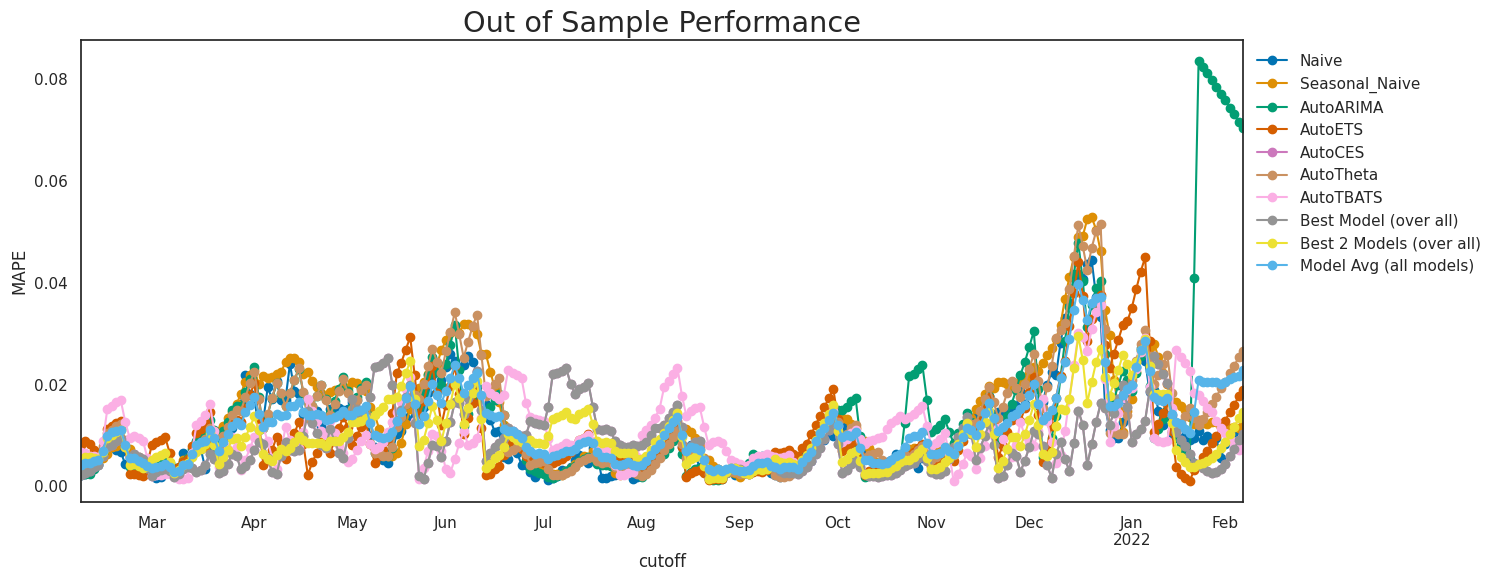

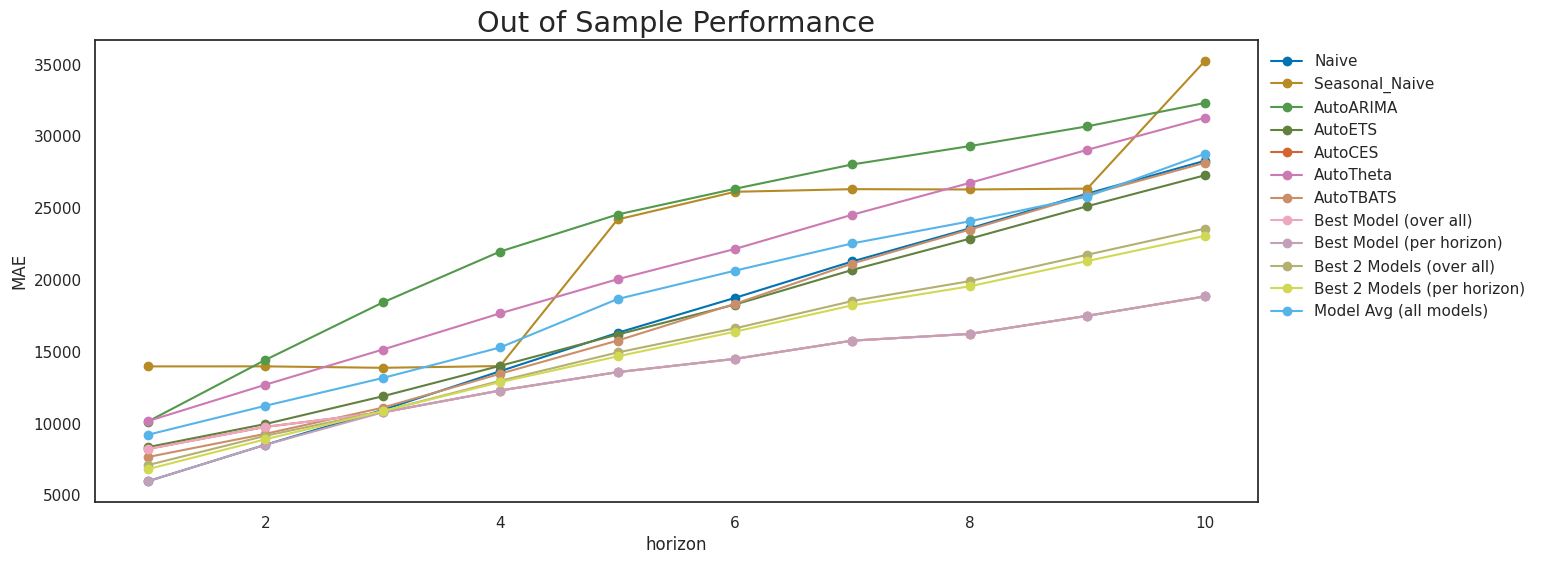

In [26]:
subset = ['AutoETS', 'AutoCES', 'AutoTBATS', 'Prophet','Model Avg (all models)']
model.plot_model_compare(score ='MAPE', view = 'cutoff')
plt.savefig(os.path.join(output_folder, f'model_compare_per_cutoff_{today}.png'), dpi=300, bbox_inches='tight')
model.plot_model_compare(score ='MAE', view = 'horizon')#, model_subset=subset + ['Best Model (per horizon)'])
plt.savefig(os.path.join(output_folder, f'model_compare_per_horizon_{today}.png'), dpi=300, bbox_inches='tight')

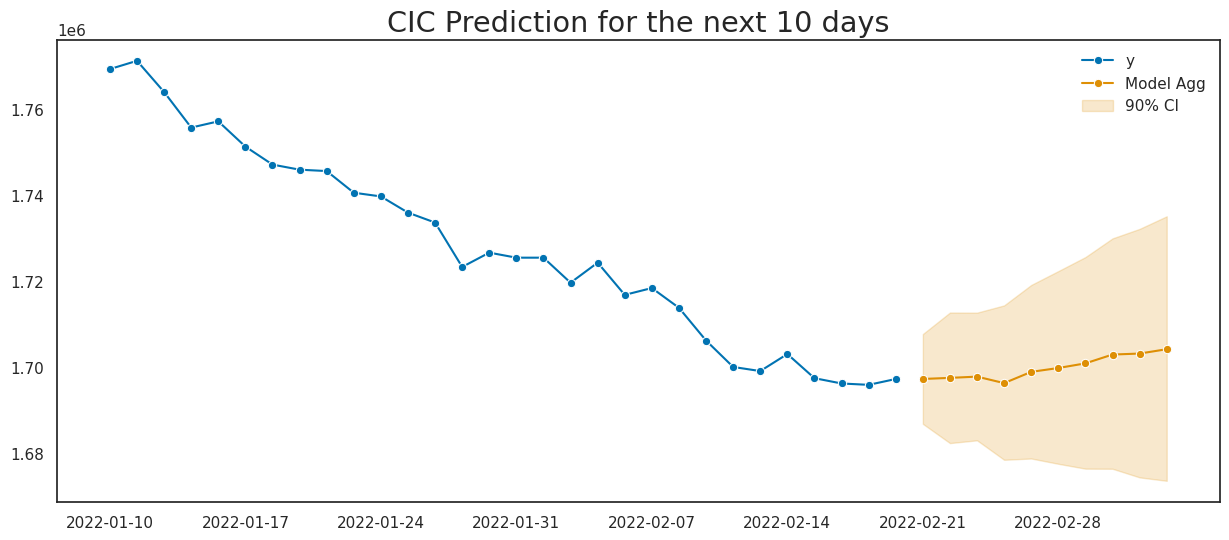

In [27]:
y_pred, y_pred_ints, preds, pred_ints = model.predict(X = holiday_type, mode='nbest_average_horizon', ret_underlying=True)
f, ax =model.plot_prediction(y_pred = y_pred,
                             models_preds = None,
                             y_pred_interval = y_pred_ints,
                             title = 'CIC Prediction for the next 10 days')

In [28]:
path = '../model_output/CIC_forecast.pkl'
model.save(path)